# The Battle of Neighborhoods

This project aims to identify the best location for setting up a coffee shop in the City of Toronto

### Import the necessary libraries

In [16]:
#import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install geocoder
import geocoder # import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library


print('Libraries imported.')

Libraries imported.


In [17]:
#read first table from wikipedia page

df_canada= pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [18]:
#check the total number of tables in the page

print(f'Total tables: {len(df_canada)}')

Total tables: 3


In [19]:
#to make the table selection easier, use the match parameter to select a subset of tables.

df_canada = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', match='Borough')
len(df_canada)

1

In [20]:
#there is a match! Extract the matched table which has been stored in df_canada

df = df_canada[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [21]:
#drop rows where borough is Not assigned
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)

#reset the index numbering
df.reset_index(drop=True, inplace=True)
df.head()


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [22]:
#display the number of rows in the dataframe
df.shape

(103, 3)

#### Import the geographical coordinates of each postal code

In [23]:
#read dataframe with geographical coordinates of each postal code
df2= pd.read_csv('http://cocl.us/Geospatial_data')


#merge the two dataframes (boroughs and geographical coordinates) to show geographical coordinates of each postal code
df_new = df.merge(df2, on='Postal Code')
df_new.head(5)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Explore Neighborhoods in Toronto

In [24]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(df_new['Borough'].unique()),
        df_new.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighbourhoods.


#### Create a map of Toronto with neighborhoods superimposed on top

Use geopy library to obtain the latitude and longitude values of Toronto

In [25]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create map of Toronto using latitude and longitude values

In [26]:
from IPython.display import display
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_new['Latitude'], df_new['Longitude'], df_new['Borough'], df_new['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
display(map_toronto)

#### Define Foursquare Credentials and Version

In [27]:
CLIENT_ID = '2LFZEE5KY44WGBFIAOZBAJUJRUN1VRYJTVNGW3GW4URRSPEK' 
CLIENT_SECRET = 'SZ0KO1GZVONF0HUDFI0P3X3GEVZTWOPQJZHLGDTG0VAXZZCJ' 
ACCESS_TOKEN = 'L10JDGKBDSWTLXHGFG1RBL5WMBPA5XAIHH03MSI2MTR3DAP4' 
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2LFZEE5KY44WGBFIAOZBAJUJRUN1VRYJTVNGW3GW4URRSPEK
CLIENT_SECRET:SZ0KO1GZVONF0HUDFI0P3X3GEVZTWOPQJZHLGDTG0VAXZZCJ


### Let's start Exploring Neighborhoods in Toronto

In [28]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let the above function run on each neighborhood and save in a new dataframe called toronto_venues.

In [29]:
toronto_venues = getNearbyVenues(names=df_new['Neighbourhood'],latitudes=df_new['Latitude'], longitudes=df_new['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [30]:
#how many venues were returned
print(toronto_venues.shape)
toronto_venues.head()

(2123, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


How many venues were returned for each neighborhood?

In [31]:
toron= toronto_venues.groupby('Neighbourhood').count().sort_values(by= 'Venue Category',ascending=False, axis=0).reset_index()
toron.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Commerce Court, Victoria Hotel",100,100,100,100,100,100
1,"First Canadian Place, Underground city",100,100,100,100,100,100
2,"Toronto Dominion Centre, Design Exchange",100,100,100,100,100,100
3,"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100
4,"Garden District, Ryerson",100,100,100,100,100,100


Visualize neighborhoods with more than 45 venues


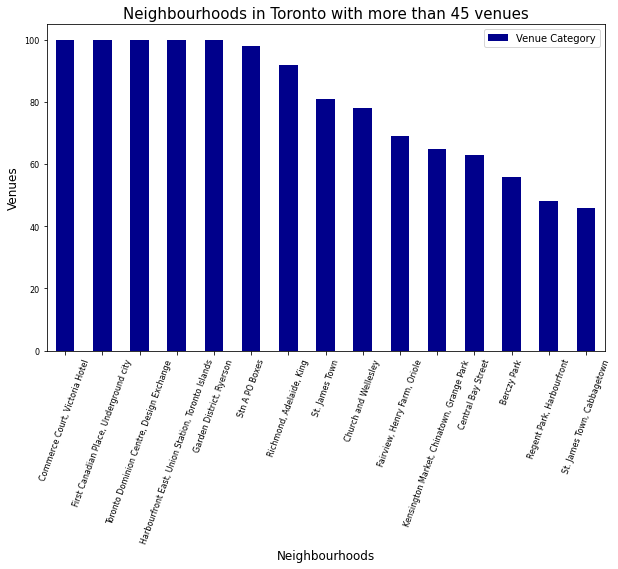

In [32]:
#create new dataframe
toron2= toron.loc[toron['Venue Category'] >= 45]
%matplotlib inline

toron2.plot(kind= 'bar', x="Neighbourhood", y="Venue Category", rot=70, figsize= (10,6), color='darkblue', fontsize= 8)

plt.title('Neighbourhoods in Toronto with more than 45 venues', fontsize=15)

plt.xlabel('Neighbourhoods', fontsize= 12)
plt.ylabel('Venues', fontsize= 12)


plt.show()


How many unique categories can be curated from all the returned venues?

In [33]:
print('There are {} uniques venue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 267 uniques venue categories.


In [34]:
toronto_venues['Venue Category'].unique()

array(['Park', 'Food & Drink Shop', 'Hockey Arena',
       'Portuguese Restaurant', 'Coffee Shop', 'Intersection', 'Bakery',
       'Distribution Center', 'Spa', 'Restaurant', 'Pub',
       'Breakfast Spot', 'Gym / Fitness Center', 'Historic Site',
       'Farmers Market', 'Chocolate Shop', 'Performing Arts Venue',
       'French Restaurant', 'Dessert Shop', 'Yoga Studio', 'Café',
       'Theater', 'Event Space', 'Shoe Store', 'Mexican Restaurant',
       'Brewery', 'Art Gallery', 'Cosmetics Shop', 'Asian Restaurant',
       'Electronics Store', 'Beer Store', 'Bank', 'Hotel',
       'Health Food Store', 'Antique Shop', 'Playground', 'Boutique',
       'Furniture / Home Store', 'Vietnamese Restaurant',
       'Clothing Store', 'Accessories Store', 'Athletics & Sports',
       'Miscellaneous Shop', 'Italian Restaurant', 'Beer Bar', 'Creperie',
       'Sushi Restaurant', 'Diner', 'Burrito Place',
       'Fried Chicken Joint', 'Japanese Restaurant', 'Smoothie Shop',
       'Sandwich Place'

## Analyze Each Neighborhood

Now, let's analyze each of the 103 neighborhoods

In [35]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Examine the new dataframe above

In [36]:
toronto_onehot.shape

(2123, 268)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0

The dataframe above shows the frequecy of the venues present in 97 neighborhoods

Confirm the new size after grouping

In [38]:
toronto_grouped.shape

(96, 268)

In [39]:
toronto_grouped_count = toronto_onehot.groupby('Neighbourhood').sum().reset_index()
toronto_grouped_count

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [40]:
toronto_grouped_count['Coffee Shop'].sum()

183

#### Let's check the number of coffee shops currently in each neighborhood

Also sort the data to know which areas has the most number of coffee shops and further explore the reasons behind this

In [41]:
coffee_shop= toronto_grouped_count.loc[:, ["Neighbourhood", "Coffee Shop"]].sort_values(by= 'Coffee Shop',ascending=False, axis=0)
coffee_shop.head()

,Neighbourhood,Coffee Shop
35,"Harbourfront East, Union Station, Toronto Islands",12
18,"Commerce Court, Victoria Hotel",12
75,Stn A PO Boxes,11
13,Central Bay Street,11
29,"First Canadian Place, Underground city",11


In [42]:
#include the boroughs, too
df_borough= df_new[['Borough', 'Neighbourhood']]

#create a new dataframe to show the number of coffee shops in the boroughs/neighborhoods
df_coffee_shops = df_borough.merge(coffee_shop, on='Neighbourhood').sort_values(by= 'Coffee Shop',ascending=False, axis=0)

#remove boroughs which do not have coffee shops
df_coffee_shops =df_coffee_shops.loc[df_coffee_shops['Coffee Shop'] != 0]
df_coffee_shops.head()

,Borough,Neighbourhood,Coffee Shop
49,Downtown Toronto,"Commerce Court, Victoria Hotel",12
35,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",12
23,Downtown Toronto,Central Bay Street,11
90,Downtown Toronto,Stn A PO Boxes,11
94,Downtown Toronto,"First Canadian Place, Underground city",11


Let's compare the number of coffee shops in a neighbourhood to the total number of other venues in that neighbourhood

In [43]:
df_coffee_shops.reset_index()
df_coffee_shop= df_coffee_shops[['Neighbourhood', 'Coffee Shop']]. reset_index()
toronto= toron[['Neighbourhood', 'Venue Category']].reset_index()

df_coffee_neigh= df_coffee_shop.merge(toronto, on='Neighbourhood')
#drop the columns not required
df_coffee_neigh.drop(columns=['index_x', 'index_y'], inplace=True)

#reset the index numbering
df_coffee_neigh.reset_index(drop=True, inplace=True)
df_coffee_neigh['Proportion %']= df_coffee_neigh['Coffee Shop']/df_coffee_neigh['Venue Category']*100
df_coffee_neigh.head()


,Neighbourhood,Coffee Shop,Venue Category,Proportion %
0,"Commerce Court, Victoria Hotel",12,100,12.000000
1,"Harbourfront East, Union Station, Toronto Islands",12,100,12.000000
2,Central Bay Street,11,63,17.460317
3,Stn A PO Boxes,11,98,11.224490
4,"First Canadian Place, Underground city",11,100,11.000000


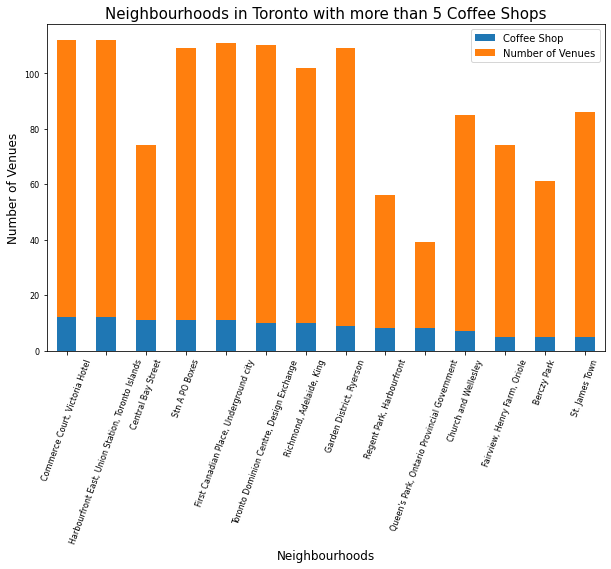

In [44]:
#stacked bar chart of neighbourhoods with more than 5 coffee shops

#create new dataframe
neighbour= df_coffee_neigh.loc[df_coffee_neigh['Coffee Shop']>=5]

neigh=neighbour[['Neighbourhood', 'Coffee Shop', 'Venue Category']]
neigh.rename(columns={'Venue Category':'Number of Venues'}, inplace=True)
neigh.plot(kind='bar', x="Neighbourhood", stacked=True, rot=70, figsize= (10,6), fontsize= 8)


plt.title('Neighbourhoods in Toronto with more than 5 Coffee Shops', fontsize=15)

plt.xlabel('Neighbourhoods', fontsize= 12)
plt.ylabel('Number of Venues', fontsize= 12)

plt.show()

In [45]:
df_coffee_shops.shape

(48, 3)

In [46]:
df_coffee_shops = df_coffee_shops.groupby('Borough').sum()
df_coffee_shops.head()

,Coffee Shop
Borough,
Central Toronto,8
Downtown Toronto,127
East Toronto,8
East York,4
Etobicoke,4


There are 184 coffee shops in the City of Toronto. The shops are in 47 Neighbourhoods and 9 Boroughs in Toronto City.

## Cluster the Neighbourhoods

#### Print each neighborhood along with the top 10 most common venues

With this, we can see the neighborhoods where coffee shop is among the most common venues, as well as the other common venues. We should be on the lookout for: businesses, kindergartens, schools, universities, business district, public transportation, consistent foot traffic. Other places include, smoothie joints, juice bars, bagel places and fast-food chains.

Neighborods will then be compared and places without coffee shops as one of the 10 most common venues, but which has similar venues as the other neighborhoods(with coffee shop) will be set apart as potential coffee establishment areas

In [47]:
num_top_venues = 10

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                        venue  freq
0                      Lounge  0.25
1              Breakfast Spot  0.25
2   Latin American Restaurant  0.25
3                Skating Rink  0.25
4           Accessories Store  0.00
5          Mexican Restaurant  0.00
6  Modern European Restaurant  0.00
7           Mobile Phone Shop  0.00
8          Miscellaneous Shop  0.00
9   Middle Eastern Restaurant  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1  Sandwich Place  0.12
2     Coffee Shop  0.12
3            Pool  0.12
4             Pub  0.12
5        Pharmacy  0.12
6             Gym  0.12
7      Hobby Shop  0.00
8          Museum  0.00
9     Men's Store  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
            venue  freq
0            Bank  0.09
1     Coffee Shop  0.09
2     Pizza Place  0.04
3     Supermarket  0.04
4     Bridal Shop  0.04
5   Shopping Mall  0.04
6  Sandwich Place  0.04
7      Restaurant  0.04
8        Pharma

#### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Electronics Store,Eastern European Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Event Space,Drugstore
1,"Alderwood, Long Branch",Pizza Place,Gym,Pharmacy,Sandwich Place,Pub,Pool,Coffee Shop,Donut Shop,Doner Restaurant,Dog Run
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Gift Shop,Fried Chicken Joint,Bridal Shop,Sandwich Place,Diner,Restaurant,Intersection,Deli / Bodega
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Dim Sum Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Thai Restaurant,Sandwich Place,Italian Restaurant,Coffee Shop,Pub,Juice Bar,Fast Food Restaurant,Restaurant,Indian Restaurant,Butcher


In [50]:
neighbourhoods_venues_sorted.shape

(96, 11)

Now, let's cluster the neighboorhoods to determine the discriminating venue categories that distinguish each cluster.

Create 10 clusters and use the elbow method to obtain the optimal number (k) of clusters

1 2 3 4 5 6 7 8 9 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

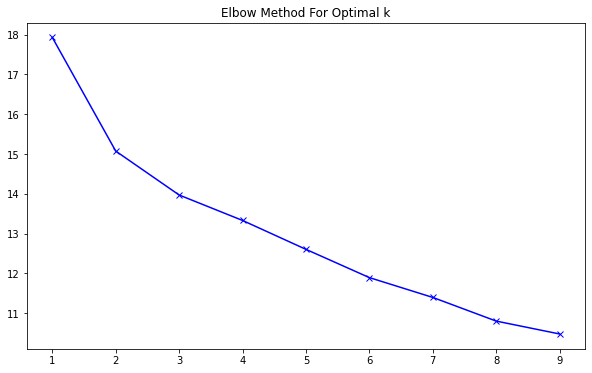

In [51]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
sum_of_squared_distances = []

# maximum of 10 clusters
K = range(1,10)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')


Although 2 seems the most optimal value as per diagram above, we are using 5 (the second best k) since this way we can break down more the number of neighbourhoods.

In [52]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = df_new.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head(2)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Intersection,Coffee Shop,Portuguese Restaurant,Hockey Arena,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


In [53]:
#drop neighborhoods whose venues could not be sorted
toronto_merged.dropna(subset=['Cluster Labels'], axis=0, inplace= True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Intersection,Coffee Shop,Portuguese Restaurant,Hockey Arena,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Park,Breakfast Spot,Restaurant,Pub,Theater,Café,Spa,Hotel
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Furniture / Home Store,Clothing Store,Boutique,Miscellaneous Shop,Event Space,Athletics & Sports,Accessories Store,Vietnamese Restaurant,Coffee Shop,Concert Hall
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,College Auditorium


We can visualise what are the most common venues and the cluster (from 0 to 5) that has been assigned to each area.

In [54]:
#change the cluster labels column type to integer
toronto_merged['Cluster Labels']= toronto_merged['Cluster Labels'].astype(int)

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

The different colours represent different clusters. Now, we can examine the most popular venues of each cluster in order to assign a name that best represents each of them.

# Examine Clusters

 Examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1

In [55]:
cluster_one= toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns]
cluster_one

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Intersection,Coffee Shop,Portuguese Restaurant,Hockey Arena,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Breakfast Spot,Restaurant,Pub,Theater,Café,Spa,Hotel
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Furniture / Home Store,Clothing Store,Boutique,Miscellaneous Shop,Event Space,Athletics & Sports,Accessories Store,Vietnamese Restaurant,Coffee Shop,Concert Hall
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,College Auditorium
6,M3B,North York,Don Mills,43.745906,-79.352188,0,Gym,Coffee Shop,Beer Store,Sporting Goods Shop,Japanese Restaurant,Restaurant,Asian Restaurant,Bike Shop,Sandwich Place,Italian Restaurant
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0,Pizza Place,Gym / Fitness Center,Gastropub,Café,Bank,Athletics & Sports,Flea Market,Intersection,Pharmacy,Breakfast Spot
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Italian Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Japanese Restaurant,Lingerie Store,Ramen Restaurant
9,M6B,North York,Glencairn,43.709577,-79.445073,0,Metro Station,Bakery,Pizza Place,Japanese Restaurant,Pub,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
11,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0,Bar,History Museum,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
12,M3C,North York,Don Mills,43.725900,-79.340923,0,Gym,Coffee Shop,Beer Store,Sporting Goods Shop,Japanese Restaurant,Restaurant,Asian Restaurant,Bike Shop,Sandwich Place,Italian Restaurant


#### Cluster 2

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] +[2]  + list(range(5, toronto_merged.shape[1]))]]


,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,1,Park,Food & Drink Shop,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
20,York,Caledonia-Fairbanks,1,Park,Women's Store,Pool,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
34,East York,"East Toronto, Broadview North (Old East York)",1,Park,Convenience Store,Rental Car Location,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Deli / Bodega
44,North York,"York Mills, Silver Hills",1,Park,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
62,York,Weston,1,Park,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
64,North York,York Mills West,1,Convenience Store,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
89,Downtown Toronto,Rosedale,1,Park,Trail,Playground,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
95,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",1,Park,River,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dance Studio


#### Cluster 3

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] +[2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,"Malvern, Rouge",2,Fast Food Restaurant,Yoga Studio,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant


#### Cluster 4

In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] +[2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Central Toronto,Lawrence Park,3,Park,Bus Line,Swim School,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Event Space


#### Cluster 5

In [59]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] +[2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",4,Bakery,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Farm


#### Analyze and Select the best cluster for setting up the coffee shop

Based on the different neighborhoods in each clusters, Clusters 1 and 2 seems to be the best clusters for establishing a coffee store, as they both have plenty of venues, businesses, offices, universities, collehigh passing foot traffic, 

However, although, coffee shops are one of the most common venues in Cluster 1, it is recommended for the client to establish the coffee shop here as the cluster is large, and has a lot of businesses, schools, parks, bus stations, and places with guaranteeed foot traffic.

The client will also have to further explore the menu, loyalty discounts, etc, offered by other  coffee s Attention will also be paid to smoothie joints, juice bars, bagel places and even fast-food chains, as they are potential competitors and will determine the products a new coffee shop should serve.

Let's try to get a list of the coffee shops, using Toronto City Hall as a centre point.

In [60]:
address = 'Toronto City Hall'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

CLIENT_ID = '2LFZEE5KY44WGBFIAOZBAJUJRUN1VRYJTVNGW3GW4URRSPEK' # your Foursquare ID
CLIENT_SECRET = 'SZ0KO1GZVONF0HUDFI0P3X3GEVZTWOPQJZHLGDTG0VAXZZCJ' # your Foursquare Secret
ACCESS_TOKEN = 'L10JDGKBDSWTLXHGFG1RBL5WMBPA5XAIHH03MSI2MTR3DAP4' # your FourSquare Access Token

#get category id of coffee shop

search_query = 'Coffee'
radius = 3000

#define url
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()

#assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

dataframe.head()


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:26: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.neighborhood,location.city,location.state,location.country,location.formattedAddress,venuePage.id
0,59f784dd28122f14f9d5d63d,HotBlack Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1613114338,False,245 Queen Street West,at St Patrick St,43.650364,-79.388669,"[{'label': 'display', 'lat': 43.65036434800487...",520,M5V 1Z4,CA,Entertainment District,Toronto,ON,Canada,"[245 Queen Street West (at St Patrick St), Tor...",463001529
1,4b44fc77f964a520cc0026e3,Timothy's World Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1613114338,False,427 University Avenue,NaN,43.654053,-79.388090,"[{'label': 'display', 'lat': 43.65405317976302...",332,NaN,CA,NaN,Toronto,ON,Canada,"[427 University Avenue, Toronto ON, Canada]",NaN
2,4b0aaa8ef964a520272623e3,Timothy's World Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1613114338,False,"483 Bay St, Bell Trinity Square",Bell Trinity Square,43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",137,M5G 2C9,CA,NaN,Toronto,ON,Canada,"[483 Bay St, Bell Trinity Square (Bell Trinity...",NaN
3,4baa9f6cf964a520817a3ae3,Timothy's World Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1613114338,False,401 Bay St.,at Richmond St. W,43.652135,-79.381172,"[{'label': 'display', 'lat': 43.65213455850074...",280,M5H 2Y4,CA,NaN,Toronto,ON,Canada,"[401 Bay St. (at Richmond St. W), Toronto ON M...",NaN
4,53e8acc4498ee294fb100183,Timothy's World Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1613114338,False,425 University Ave,Dundas,43.654270,-79.387448,"[{'label': 'display', 'lat': 43.65427, 'lng': ...",287,M5G 1T6,CA,NaN,Toronto,ON,Canada,"[425 University Ave (Dundas), Toronto ON M5G 1...",NaN


In [61]:
'There are {} coffee shops around Toronto city Hall between a distance of {} and {}'.format(dataframe.shape[0],(dataframe['location.distance'].min()), (dataframe['location.distance'].max()) )

'There are 50 coffee shops around Toronto city Hall between a distance of 137 and 2247'

In [62]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#rename the columns
dataframe_filtered.rename(columns={'postalCode':'Postal Code'}, inplace=True)

dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,Postal Code,cc,neighborhood,city,state,country,formattedAddress,id
0,HotBlack Coffee,Coffee Shop,245 Queen Street West,at St Patrick St,43.650364,-79.388669,"[{'label': 'display', 'lat': 43.65036434800487...",520,M5V 1Z4,CA,Entertainment District,Toronto,ON,Canada,"[245 Queen Street West (at St Patrick St), Tor...",59f784dd28122f14f9d5d63d
1,Timothy's World Coffee,Coffee Shop,427 University Avenue,NaN,43.654053,-79.388090,"[{'label': 'display', 'lat': 43.65405317976302...",332,NaN,CA,NaN,Toronto,ON,Canada,"[427 University Avenue, Toronto ON, Canada]",4b44fc77f964a520cc0026e3
2,Timothy's World Coffee,Coffee Shop,"483 Bay St, Bell Trinity Square",Bell Trinity Square,43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",137,M5G 2C9,CA,NaN,Toronto,ON,Canada,"[483 Bay St, Bell Trinity Square (Bell Trinity...",4b0aaa8ef964a520272623e3
3,Timothy's World Coffee,Coffee Shop,401 Bay St.,at Richmond St. W,43.652135,-79.381172,"[{'label': 'display', 'lat': 43.65213455850074...",280,M5H 2Y4,CA,NaN,Toronto,ON,Canada,"[401 Bay St. (at Richmond St. W), Toronto ON M...",4baa9f6cf964a520817a3ae3
4,Timothy's World Coffee,Coffee Shop,425 University Ave,Dundas,43.654270,-79.387448,"[{'label': 'display', 'lat': 43.65427, 'lng': ...",287,M5G 1T6,CA,NaN,Toronto,ON,Canada,"[425 University Ave (Dundas), Toronto ON M5G 1...",53e8acc4498ee294fb100183


In [63]:
#drop coffee shops without postal codes

dataframe_filtered2= dataframe_filtered[['name', 'address', 'lat', 'lng', 'Postal Code','distance','formattedAddress']]

dataframe_filtered2.dropna(subset=['Postal Code'], axis=0, inplace= True)
dataframe_filtered2.reset_index(drop=True, inplace=True)

#lets split the postal code and keep only the first part of the postal code
dataframe_filtered2[['First','Last']] = dataframe_filtered2['Postal Code'].str.split(' ',expand=True)
dataframe_filtered2.rename(columns={'Postal Code':'Postals', 'First':'Postal Code'}, inplace= True)
dataframe_filtered2.head()


,name,address,lat,lng,Postals,distance,formattedAddress,Postal Code,Last
0,HotBlack Coffee,245 Queen Street West,43.650364,-79.388669,M5V 1Z4,520,"[245 Queen Street West (at St Patrick St), Tor...",M5V,1Z4
1,Timothy's World Coffee,"483 Bay St, Bell Trinity Square",43.653436,-79.382314,M5G 2C9,137,"[483 Bay St, Bell Trinity Square (Bell Trinity...",M5G,2C9
2,Timothy's World Coffee,401 Bay St.,43.652135,-79.381172,M5H 2Y4,280,"[401 Bay St. (at Richmond St. W), Toronto ON M...",M5H,2Y4
3,Timothy's World Coffee,425 University Ave,43.654270,-79.387448,M5G 1T6,287,"[425 University Ave (Dundas), Toronto ON M5G 1...",M5G,1T6
4,Balzac's Coffee,122 Bond Street,43.657854,-79.379200,M5B 1X8,611,"[122 Bond Street (at Gould St.), Toronto ON M5...",M5B,1X8


Now, let's extract the coffee shops in the recommended cluster: Cluster 1, from the list of Coffee shops around our reference point, i.e., Toronto City Hall

In [64]:
cluster_rec= cluster_one[['Borough', 'Neighbourhood', 'Postal Code']]
# Format with commas and round off to two decimal places in pandas 
#pd.options.display.float_format = '{:.2f}'.format

cluster1_recommend= dataframe_filtered2.merge(cluster_rec, on='Postal Code')
cluster1_recommend.head()

,name,address,lat,lng,Postals,distance,formattedAddress,Postal Code,Last,Borough,Neighbourhood
0,HotBlack Coffee,245 Queen Street West,43.650364,-79.388669,M5V 1Z4,520,"[245 Queen Street West (at St Patrick St), Tor...",M5V,1Z4,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har..."
1,Second Cup Coffee Co.,200 Front St W,43.645009,-79.385812,M5V 3K2,967,"[200 Front St W (in Simcoe Place), Toronto ON ...",M5V,3K2,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har..."
2,Cozy Coffee,200 Queen St W,43.650535,-79.388953,M5V 1Z2,524,"[200 Queen St W (St Patrick St), Toronto ON M5...",M5V,1Z2,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har..."
3,Timothy's World Coffee,"483 Bay St, Bell Trinity Square",43.653436,-79.382314,M5G 2C9,137,"[483 Bay St, Bell Trinity Square (Bell Trinity...",M5G,2C9,Downtown Toronto,Central Bay Street
4,Timothy's World Coffee,425 University Ave,43.654270,-79.387448,M5G 1T6,287,"[425 University Ave (Dundas), Toronto ON M5G 1...",M5G,1T6,Downtown Toronto,Central Bay Street


In [65]:
'Out of the 50 coffee shops around Toronto City Hall, there are {} coffee shops in Cluster 1 between a distance of {} and {} from the Hall'.format(cluster1_recommend.shape[0],(cluster1_recommend['distance'].min()), (cluster1_recommend['distance'].max()) )

'Out of the 50 coffee shops around Toronto City Hall, there are 32 coffee shops in Cluster 1 between a distance of 137 and 2247 from the Hall'

In [66]:
cluster1_recommend.name.value_counts().reset_index().rename(columns={'name':'count', 'index':'name'}).head()

,name,count
0,Timothy's World Coffee,8
1,Balzac's Coffee,3
2,Second Cup Coffee Co. featuring Pinkberry Froz...,2
3,Cozy Coffee,1
4,Seattle's Best Coffee,1


Timothy's World Coffee seems to be the leading Coffee provider in Cluster 1 with 8 outlets, floowed by Balzac's Coffee with 3 outlets. 

Now, let's visualize the Coffee Shops in Cluster 1

In [67]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Toronto City Hall
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Toronto City Hall',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Coffee Shops as blue circle markers
for lat, lng, name, Neighbourhood in zip(cluster1_recommend.lat, cluster1_recommend.lng, cluster1_recommend.name, cluster1_recommend.Neighbourhood):
    label= '{}, {}'.format(name, Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
display(venues_map)

In [68]:
#let's compare the number of coffee shops in cluster 1 to the total number of coffee shops per neighbourhood

cluster1_recommended= cluster1_recommend.merge(df_coffee_neigh, on='Neighbourhood')

cluster1_recommended_shops= cluster1_recommended[['name', 'address','Neighbourhood', 'Borough', 'Coffee Shop', 'Venue Category','distance', 'Proportion %' ]]
cluster1_recommended_shops.head()

,name,address,Neighbourhood,Borough,Coffee Shop,Venue Category,distance,Proportion %
0,Timothy's World Coffee,"483 Bay St, Bell Trinity Square",Central Bay Street,Downtown Toronto,11,63,137,17.460317
1,Timothy's World Coffee,425 University Ave,Central Bay Street,Downtown Toronto,11,63,287,17.460317
2,Second Cup Coffee Co. featuring Pinkberry Froz...,"600 University Avenue, Room #202",Central Bay Street,Downtown Toronto,11,63,686,17.460317
3,Seattle's Best Coffee,108 Chestnut St,Central Bay Street,Downtown Toronto,11,63,185,17.460317
4,NEO COFFEE BAR,770 Bay Street Unit 3,Central Bay Street,Downtown Toronto,11,63,741,17.460317


## Recommendation/Conclusion

If we compare the number of coffee shops in cluster 1 to the total number of coffee shops per neighbourhood, we can identify two (2) unique neighbourhoods: Garden District Ryeson and Central Bay Street. While Central Bay Street seems to have enough number of coffee shops: 11 coffee shops out of 60 venues (8 of these coffee shops are in Cluster 1), in Garden District Ryeson, out of the total 100 venues there are 9 coffee shops, 4 of which are in cluster 1.

Therefore, the best neighbourhood for establishing a new coffee shop is Garden District Ryeson. This recommended neighborhood has a businesses, universities, parks, gardens, bus lines, and guaranteed passing foot trafic. Foursquare API should be further used to get the competitors reviews and users tips to have an idea of the deals/ discounts/ loyalty schemes the competitors are offering